In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from tqdm import tqdm
from warnings import warn
from datetime import datetime

In [6]:
def clean_data(df, duplicate_cols=None, drop_missing_cols=None):
    """Enhanced data cleaning with date validation"""
    # Convert and validate dates
    df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
    df = df.dropna(subset=['Order_Date'])
    
    # Remove duplicates
    if duplicate_cols:
        df = df.drop_duplicates(subset=duplicate_cols, keep='first')
    
    # Handle missing values
    if drop_missing_cols:
        df = df.dropna(subset=drop_missing_cols)
    
    # Validate critical columns
    df = df[df['Quantity'] > 0]
    df = df[(df['Sales'] > 0) & (df['Profit'].notna())]
    
    return df

In [7]:
def engineer_features(df):
    """Create temporal features and price calculations"""
    # Temporal features
    df['DayOfWeek'] = df['Order_Date'].dt.dayofweek
    df['Month'] = df['Order_Date'].dt.month
    df['Year'] = df['Order_Date'].dt.year
    
    # Price calculations
    df['Price'] = df['Sales'] / df['Quantity']
    df['Cost'] = (df['Sales'] - df['Profit'] - df['Shipping_Cost']) / df['Quantity']
    
    # Filter valid prices
    df = df[(df['Price'] > 0) & (df['Cost'] > 0)]
    
    return df

In [8]:
def split_data(df, test_size=0.2):
    """Smart data splitting with fallback"""
    try:
        # Time-based split
        split_date = df['Order_Date'].quantile(1 - test_size)
        train_data = df[df['Order_Date'] < split_date]
        test_data = df[df['Order_Date'] >= split_date]
        
        if len(test_data) == 0:
            raise ValueError
    except:
        # Random split fallback
        warn("Time-based split failed - using random split")
        train_data, test_data = train_test_split(df, test_size=test_size, random_state=42)
    
    return train_data, test_data

In [9]:
try:
    # Load and preprocess data
    data = pd.read_csv("E-commerce Dataset.csv")
    data = clean_data(data, 
                     duplicate_cols=['Order_Date', 'Customer_Id'],
                     drop_missing_cols=['Sales', 'Quantity', 'Profit'])
    
    # Feature engineering
    data = engineer_features(data)
    
    # Check for empty data
    if data.empty:
        raise ValueError("Clean dataset is empty after preprocessing")
    
    # Split data
    train_data, test_data = split_data(data)

except Exception as e:
    print(f"\nError: {str(e)}")
    print("Debugging Tips:")
    print("- Verify input CSV format and columns")
    print("- Check date format in Order_Date (YYYY-MM-DD)")
    print("- Ensure numeric columns contain valid numbers")

In [10]:
# Define features
numeric_features = ['Price', 'Discount', 'Cost', 'DayOfWeek', 'Month']
categorical_features = ['Gender', 'Device_Type', 'Customer_Login_type', 'Payment_method']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

# Model pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100, 150],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

model = GridSearchCV(pipeline, param_grid, 
                    cv=TimeSeriesSplit(n_splits=3),
                    scoring='neg_mean_squared_error')

# Train model
model.fit(train_data[numeric_features + categorical_features], 
         train_data['Quantity'])

print(f"Best Parameters: {model.best_params_}")
print(f"Best RMSE: {np.sqrt(-model.best_score_):.2f}")

Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 150}
Best RMSE: 0.46


In [11]:
def optimize_price(row):
    """Robust price optimization with progress tracking"""
    try:
        if pd.isna(row['Cost']) or row['Cost'] <= 0:
            return row['Price']
        
        # Price bounds
        min_price = max(row['Cost'] * 0.8, row['Price'] * 0.7)
        max_price = min(row['Cost'] * 2.0, row['Price'] * 1.5)
        
        # Feature vector
        X = pd.DataFrame([row[numeric_features + categorical_features]])
        
        # Profit function
        def profit(price):
            X_temp = X.copy()
            X_temp['Price'] = price
            try:
                X_trans = model.best_estimator_['preprocessor'].transform(X_temp)
                pred_qty = model.best_estimator_['regressor'].predict(X_trans)[0]
                return -((price - row['Cost']) * max(pred_qty, 0) - row['Shipping_Cost'])
            except:
                return np.inf
            
        result = minimize_scalar(profit, bounds=(min_price, max_price), method='bounded')
        return round(result.x, 2)
    except:
        return row['Price']

# Apply optimization
if not test_data.empty:
    test_data['Optimal_Price'] = test_data.progress_apply(optimize_price, axis=1)
    
    # Generate predictions
    test_data['Predicted_Quantity'] = model.predict(
        test_data[numeric_features + categorical_features]
    )

100%|██████████| 10055/10055 [20:55<00:00,  8.01it/s]
C:\Users\medse\AppData\Local\Temp\ipykernel_20500\3350587293.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Optimal_Price'] = test_data.progress_apply(optimize_price, axis=1)
C:\Users\medse\AppData\Local\Temp\ipykernel_20500\3350587293.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Quantity'] = model.predict(


C:\Users\medse\AppData\Local\Temp\ipykernel_20500\2934123510.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Profit_Current'] = (test_data['Price'] - test_data['Cost']) * test_data['Quantity'] - test_data['Shipping_Cost']
C:\Users\medse\AppData\Local\Temp\ipykernel_20500\2934123510.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Profit_Optimal'] = (test_data['Optimal_Price'] - test_data['Cost']) * test_data['Predicted_Quantity'] - test_data['Shipping_Cost']



Profit Lift: 8.52%


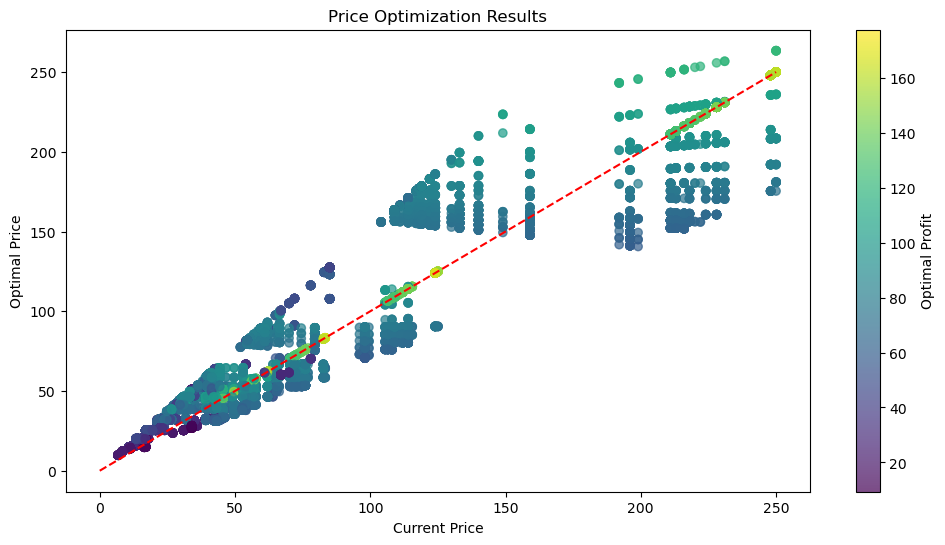


Top 5 Improvements:
          Product  Price  Optimal_Price  Profit_Current  Profit_Optimal
11882  T - Shirts  124.0          124.0           163.0      177.462057
13939  T - Shirts  124.0          124.0           163.0      177.462057
14390  T - Shirts  124.0          124.0           163.0      177.462057
6789   T - Shirts  124.0          124.0           163.0      176.630501
10056  T - Shirts  124.0          124.0           163.0      176.630501


In [13]:
if not test_data.empty:
    # Calculate profits
    test_data['Profit_Current'] = (test_data['Price'] - test_data['Cost']) * test_data['Quantity'] - test_data['Shipping_Cost']
    test_data['Profit_Optimal'] = (test_data['Optimal_Price'] - test_data['Cost']) * test_data['Predicted_Quantity'] - test_data['Shipping_Cost']
    
    # Calculate profit lift
    if test_data['Profit_Current'].sum() != 0:
        profit_lift = ((test_data['Profit_Optimal'].sum() - test_data['Profit_Current'].sum()) / 
                      test_data['Profit_Current'].sum())
        print(f"\nProfit Lift: {profit_lift*100:.2f}%")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['Price'], test_data['Optimal_Price'], 
               c=test_data['Profit_Optimal'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Optimal Profit')
    plt.plot([0, test_data['Price'].max()], [0, test_data['Price'].max()], 'r--')
    plt.xlabel('Current Price')
    plt.ylabel('Optimal Price')
    plt.title('Price Optimization Results')
    plt.show()
    
    # Show best performers
    print("\nTop 5 Improvements:")
    print(test_data.nlargest(5, 'Profit_Optimal')[['Product', 'Price', 'Optimal_Price', 'Profit_Current', 'Profit_Optimal']])
    
else:
    print("\nNo test data available for optimization")